In [1]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 3.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 72.6 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 65.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 74.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 68.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 13.1 MB/

In [3]:
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from math import sqrt
from numpy import split
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from numpy import vstack
from pandas import read_csv
from numpy import mean
from numpy import std
from numpy import dstack

In [4]:
# cnn model for the har dataset
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

2022-09-28 11:42:05.889550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 11:42:06.053402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-09-28 11:42:06.053440: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-28 11:42:06.093618: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022

In [5]:
df_raw = pd.read_csv('/notebooks/Dataset_with_ind_M5.csv')

In [6]:
# dataset['Unnamed: 0'] = pd.to_datetime(dataset['Unnamed: 0'], unit='s', utc=True)
df = df_raw.drop(['Unnamed: 0','time'], axis=1)
# df.index.name = None

In [7]:
df1 = df.values

In [8]:
s = MinMaxScaler()
dataset = s.fit_transform(df1)

In [9]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[0:-12000], data[-12000:]
    # restructure into windows of weekly data
    return train, test

In [10]:
# split into train and test
train, test = split_dataset(dataset)

In [12]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=3):    
        
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(train)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(train):            
            X.append(train[in_start:in_end, :])
            y.append(train[in_end:out_end, 0]) 
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)        
    # define parameters
    verbose, epochs, batch_size = 1, 5, 16
    initial_learning_rate = 0.0001
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu',
                        input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(25, activation='tanh', return_sequences=True))
    model.add(TimeDistributed(Dense(50, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse',     
                    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
                    metrics=[tf.keras.metrics.MeanSquaredError()])    
    model.summary()
    filepath = "/notebooks/Models_H1/Model_Conv_LSTM_batch64.h5"
    my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='loss', mode="min"),
    tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir='/notebooks/Callbacks', update_freq='batch')]
    # fit network
    model.fit(train_x, train_y, epochs=epochs, validation_split=0.3, batch_size=batch_size, verbose=verbose, callbacks=my_callbacks)
    
    return model

In [449]:
# evaluate model and get scores
n_input = 1000
model = build_model(train, n_input)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 998, 32)           2048      
                                                                 
 conv1d_25 (Conv1D)          (None, 996, 32)           3104      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 498, 32)          0         
 g1D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 15936)             0         
                                                                 
 repeat_vector_12 (RepeatVec  (None, 3, 15936)         0         
 tor)                                                            
                                                                 
 lstm_12 (LSTM)              (None, 3, 25)           

In [14]:
model = load_model('/notebooks/Models_H1/Model_Conv_LSTM_batch64.h5')

In [ ]:
model1 = load_model('/notebooks/Models_H1/Model_Conv_LSTM_batch64.h5')

In [15]:
n_input = 1000
X_test, y_test = to_supervised(test, n_input)

In [16]:
preds_new = model.predict(X_test, verbose=1)

2022-09-28 11:42:29.292771: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 923748000 exceeds 10% of free system memory.


344/344 [==============================] - 4s 9ms/step


In [17]:
preds_new_shaped = preds_new.reshape((preds_new.shape[0]*preds_new.shape[1], preds_new.shape[2]))
trainPredict_dataset_like = np.zeros(shape=(len(preds_new_shaped), 21))
trainPredict_dataset_like[:,0] = preds_new_shaped[:,0]
preds_new_inversed = s.inverse_transform(trainPredict_dataset_like)[:,0]
preds_new_total = array(split(preds_new_inversed, len(preds_new_inversed)/3))

In [18]:
y_test_shaped = y_test.reshape((y_test.shape[0]*y_test.shape[1], 1))
trainPredict_dataset_like = np.zeros(shape=(len(y_test_shaped), 21))
trainPredict_dataset_like[:,0] = y_test_shaped[:,0]
y_test_inversed = s.inverse_transform(trainPredict_dataset_like)[:,0]
y_test_total = array(split(y_test_inversed, len(y_test_inversed)/3))

In [24]:
df_close = df['close'][25565:25765]

In [25]:
df_close_r = df_close.reset_index().drop('index', axis=1)

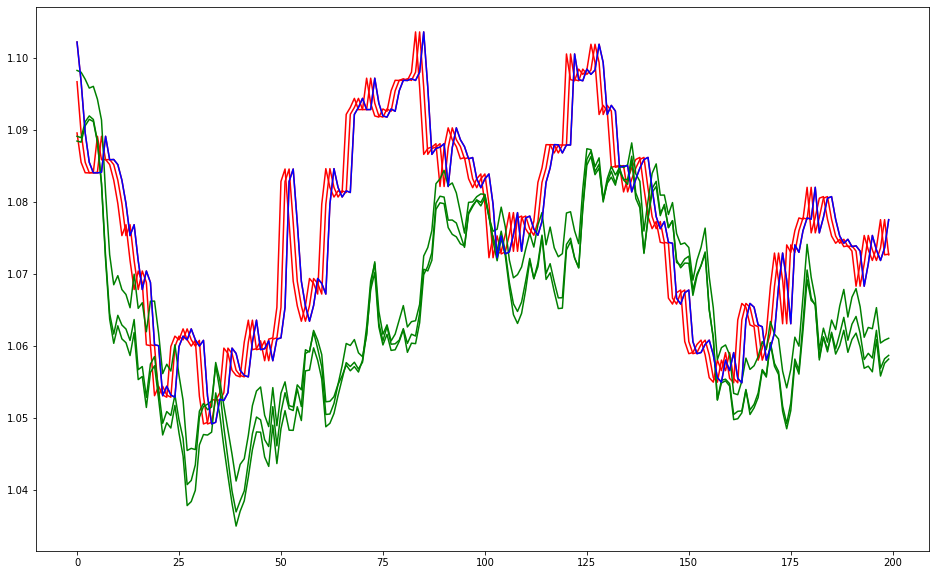

In [441]:
plt.figure(figsize=(16,10))
plt.plot(y_test_total[0:200], color='red')
plt.plot(preds_new_total[0:200], color='green')
plt.plot(df_close_r, color='blue')
plt.show()

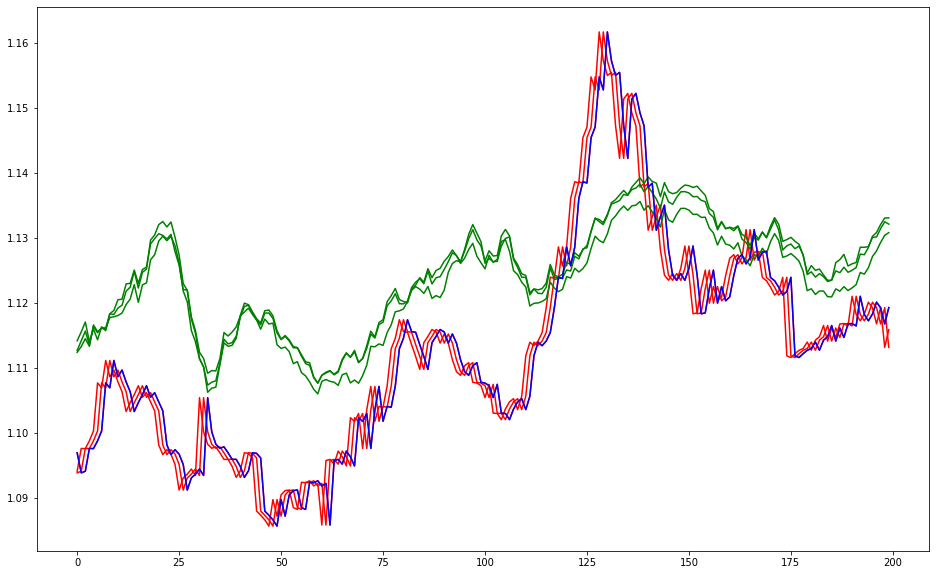

In [26]:
plt.figure(figsize=(16,10))
plt.plot(y_test_total[0:200], color='red')
plt.plot(preds_new_total[0:200], color='green')
plt.plot(df_close_r, color='blue')
plt.show()